In [1]:
import numpy as np
import os, sys
import matplotlib
matplotlib.rcParams['svg.fonttype'] = 'none'
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("colorblind")
sns.set_context("paper", font_scale=2)
sns.set_style("white")
%matplotlib inline

In [2]:
import pystan

In [43]:
N_time = 24
N0 = 100
N1 = 10
Add_y = 0.3
Add_x = np.arange(7, 12)
SD = 0.3

In [44]:
X = np.arange(N_time)
y0 = np.sin(X/N_time*2*np.pi)

In [45]:
y1 = y0.copy()
y1[Add_x] = y1[Add_x] + Add_y

In [46]:
# 先頭列は元コード typeに対応
Y0 = np.random.normal(scale = SD, size = (N_time+1)*N0).reshape(N0, N_time+1)
for row in range(Y0.shape[0]):
    Y0[row, :] = np.insert(arr=Y0[row, 1:] + y0, obj=0, values=0)
Y1 = np.random.normal(scale = SD, size = (N_time+1)*N1).reshape(N1, N_time+1)
for row in range(Y1.shape[0]):
    Y1[row, :] = np.insert(arr=Y1[row, 1:] + y1, obj=0, values=1)

In [47]:
d = np.r_[Y0, Y1]

In [48]:
d0 = d[d[:, 0] == 0]
d1 = d[d[:, 0] == 1]

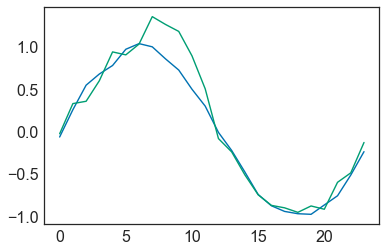

In [49]:
plt.plot(X, np.mean(d0, axis=0)[1:])
plt.plot(X, np.mean(d1, axis=0)[1:])

In [50]:
stanmodel = pystan.StanModel(file="model2.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_00fcab37ad452b75c43f5242392023b2 NOW.


In [51]:
stan_data = {"N_time": N_time, "N0": N0, "N1": N1, "X": X, "Y0": d0[:, 1:], "Y1": d1[:, 1:]}
fit = stanmodel.sampling(data=stan_data, iter=1500, warmup=500, seed=123)

In [52]:
fit

Inference for Stan model: anon_model_00fcab37ad452b75c43f5242392023b2.
4 chains, each with iter=1500; warmup=500; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]        -0.05  4.5e-4   0.03  -0.11  -0.07  -0.05  -0.04 1.0e-3   4000    1.0
mu[1]         0.26  3.9e-4   0.02   0.21   0.24   0.26   0.28   0.31   4000    1.0
mu[2]         0.52  3.9e-4   0.02   0.47    0.5   0.52   0.53   0.57   4000    1.0
mu[3]         0.68  3.9e-4   0.02   0.63   0.66   0.68   0.69   0.72   4000    1.0
mu[4]         0.81  3.9e-4   0.02   0.76   0.79   0.81   0.83   0.86   4000    1.0
mu[5]         0.96  3.8e-4   0.02   0.91   0.94   0.96   0.97    1.0   4000    1.0
mu[6]         1.03  3.8e-4   0.02   0.98   1.01   1.03   1.04   1.08   4000    1.0
mu[7]         0.99  3.8e-4   0.02   0.95   0.98   0.99   1.01   1.04   4000    1.0
mu[8]         0.87  3.8e-4   0.02   0.83   0.86   0.87   0.89   0

In [53]:
la = fit.extract(permuted=True)

In [56]:
np.percentile(la["di"], 5, axis=0)

array([-0.09814635, -0.09380677, -0.13595   , -0.12342947, -0.07659632,
       -0.08718245, -0.08791793,  0.20933615,  0.26227422,  0.26999243,
        0.22408141,  0.0267507 , -0.10653118, -0.09153364, -0.08638296,
       -0.07957706, -0.06602153, -0.05034174, -0.04494704, -0.03577186,
       -0.04294488, -0.01832398, -0.02638638, -0.02817008])

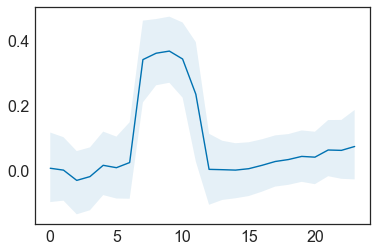

In [59]:
plt.plot(X, np.mean(la["di"], axis=0))
plt.fill_between(X, np.percentile(la["di"], 5, axis=0), np.percentile(la["di"], 95, axis=0), alpha=0.1)

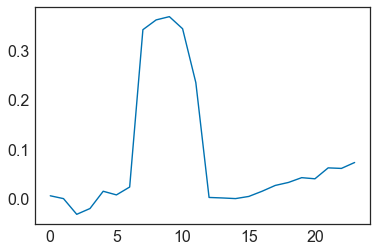

In [55]:
plt.plot(np.mean(fit["di"], axis=0))

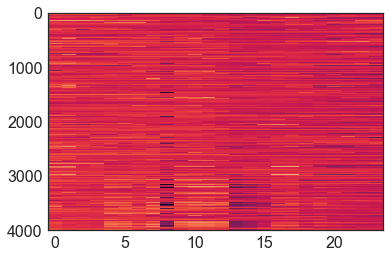

In [26]:
plt.imshow(fit["di"], aspect="auto")

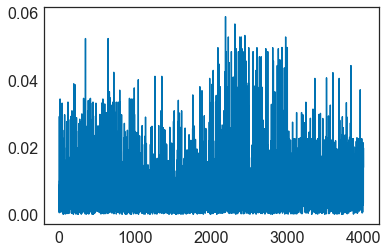

In [21]:
plt.plot(fit["s_di"])

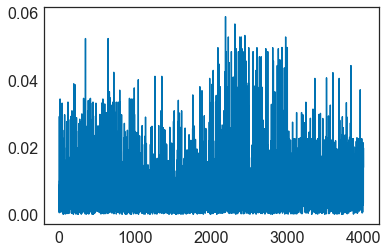

In [12]:
plt.plot(la["s_di"])

In [13]:
!cat model2.stan

data {
  int N_time;
  int N0;
  int N1;
  int X[N_time];
  vector[N_time] Y0[N0];
  vector[N_time] Y1[N1];
}

parameters {
  vector[N_time] mu;
  real di0;
  vector<lower=-pi()/2, upper=pi()/2>[N_time-1] di_unif;
  real<lower=0> s_mu;
  real<lower=0> s_di;
  real<lower=0> s_Y;
}

transformed parameters {
  vector[N_time] di;
  vector[N_time] y1_mean;
  di[1] <- di0;
  for (t in 2:N_time)
    di[t] <- di[t-1] + s_di*tan(di_unif[t-1]);
  y1_mean <- mu + di;
}

model {
  for (t in 3:N_time)
    mu[t] ~ normal(2*mu[t-1] - mu[t-2], s_mu);
  for (n in 1:N0)
    Y0[n] ~ normal(mu, s_Y);
  for (n in 1:N1)
    Y1[n] ~ normal(y1_mean, s_Y);
}


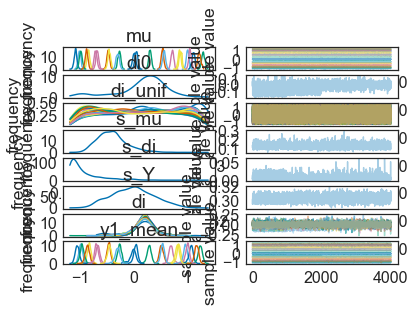

In [25]:
#fig, ax = plt.subplots(1, 1, figsize=(10, 20))
plt.figure(figsize=(10, 10))
fit.plot();

In [24]:
help(fit.traceplot)

Help on built-in function traceplot:

traceplot(...) method of stanfit4anon_model_00fcab37ad452b75c43f5242392023b2_390577511726092430.StanFit4Model instance
    Visualize samples from posterior distributions
    
    Parameters
    ---------
    pars : {str, sequence of str}, optional
        parameter name(s); by default use all parameters of interest
    dtypes : dict
        datatype of parameter(s).
        If nothing is passed, np.float will be used for all parameters.
        If np.int is specified, the histogram will be visualized, not but
        kde.

